# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv4_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version: v6 - Run with option to not use IN-CORE
- 2023-01-27 - Generalize workflow using new Lumberton Building Data
- 2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [20]:
# Do you want to use IN-CORE Dataservice? If yes, set to True
use_incore = False

In [21]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted
import scooby # Reports Python environment

# Check if using IN-CORE Dataservice
if use_incore:
    from pyincore import IncoreClient, Dataset, DataService

In [73]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_00e_geoutilities import spatial_join_points_to_poly
from pyncoda.ncoda_00h_bldg_archetype_structure import *
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions
from pyncoda.CommunitySourceData.nsi_sec_usace_army_mil.nsi_01a_downloadfiles import download_nsi_files


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz','ipyleaflet','seaborn']))


--------------------------------------------------------------------------------
  Date: Mon May 22 17:12:50 2023 Eastern Daylight Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.3.5
          pyincore : Module not found
      pyincore_viz : Module not found
        ipyleaflet : Module not found
           seaborn : 0.11.2
             numpy : 1.24.2
             scipy : 1.10.0
           IPython : 8.10.0
        matplotlib : 3.6.3
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [24]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\github\\intersect-community-data'

### Required Information: 


In [72]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/

# NOTE on file path length. WINDOWS has a limit of 260 characters for file path length.
# Community name needs to be short to avoid this limit.

communities = {'Beaumont_TX' : {
                    'community_name' : 'Beaumont, TX',
                    'focalplace_name' : 'Beaumont',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48245', 'Name' : 'Jefferson, TX'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Jefferson County, TX',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }

version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [27]:
if use_incore:
    client = IncoreClient()
    # IN-CORE caches files on the local machine, it might be necessary to clear the memory
    client.clear_cache() 

In [28]:
if use_incore:
    # create data_service object for loading files
    data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [29]:
generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder,
                    use_incore=     use_incore
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

# If using IN-CORE
if use_incore:
    # Housing Unit inventory
    housing_unit_inv_id = hui_dataset_id
    # load housing unit inventory as pandas dataframe
    housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
    filename = housing_unit_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

    # Convert CSV to Pandas Dataframe
    housing_unit_inv_df = pd.read_csv(filename, header="infer")
else:
    housing_unit_inv_df = hui_dataset_id
    hui_dataset_id = 'local'

Generating Housing Unit Inventory v2.0.0 data for Pentwater, MI
Oceana County, MI : county FIPS Code 26127
File already exists, skipping: OutputData/OceanaCounty_MI/../hui_v2-0-0_Oceana_MI_2010_rs1000.csv
Checking output for huid
Checking output for blockid
Checking output for bgid
Checking output for tractid
Checking output for FIPScounty
Checking output for numprec
Checking output for ownershp
Checking output for race
Checking output for hispan
Checking output for family
Checking output for vacancy
Checking output for gqtype
Checking output for incomegroup
Checking output for hhinc
Checking output for randincome
Checking output for poverty
Checking huid Data Type
   Current type: <class 'pandas.core.series.Series'> Expected type <class 'str'>
Checking blockid Data Type
   Current type: <class 'pandas.core.series.Series'> Expected type <class 'str'>
    Length of blockid is correct
Checking bgid Data Type
   Current type: <class 'pandas.core.series.Series'> Expected type <class 'str'>

In [30]:
housing_unit_inv_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,vacancy,gqtype,incomegroup,hhinc,randincome,poverty
0,B261270103001001H001,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,0,0,12,4,84651.0,0.0
1,B261270103001001H002,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,0,0,3,2,19695.0,0.0
2,B261270103001001H003,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,0,0,2,1,13776.0,0.0
3,B261270103001001H004,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,0,0,9,3,47398.0,0.0
4,B261270103001001H005,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,0,0,11,3,69564.0,0.0


## Generate Address Point Inventory

In [33]:
for community in communities.keys():
    # Set parameters for Address point generation
    bldg_inv_id = communities[community]['building_inventory']['id']
    archetype_var = communities[community]['building_inventory']['archetype_var']
    building_area_var = communities[community]['building_inventory']['building_area_var']
    building_area_cutoff = communities[community]['building_inventory']['building_area_cutoff']
    residential_archetypes = communities[community]['building_inventory']['residential_archetypes']
    
    # load building inventory
    # If using IN-CORE
    if use_incore:
        # Get the Unique ID
        bldg_uniqueid = 'guid'
        # Building inventory ID
        bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
        filename = bldg_inv.get_file_path('shp')
        print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)
        bldg_inv_gdf = gpd.read_file(filename)
    # Check if building inventory is comes  from a filename if filename key exists
    elif 'filename' in communities[community]['building_inventory'].keys():
        # Get the Unique ID
        bldg_uniqueid = communities[community]['building_inventory']['bldg_uniqueid']
        
        print("Building inventory is from a file")
        bldg_filename = communities[community]['building_inventory']['filename']
        bldg_inv_gdf = gpd.read_file(bldg_filename)
    # Check if building inventory is from NSI
    elif 'NSI' in bldg_inv_id:
        # Get the Unique ID
        bldg_uniqueid = communities[community]['building_inventory']['bldg_uniqueid']
        # make an empty dictionary for saving county NSI files
        county_nsi_gdf = {}
        for county in communities[community]['counties'].keys():
            county_fips = communities[community]['counties'][county]['FIPS Code']
            state_county_name  = communities[community]['counties'][county]['Name']
            print("Downloading NSI files for:")
            print(state_county_name,': county FIPS Code',county_fips)
            county_nsi_gdf[county_fips] = download_nsi_files(county_fips=county_fips)
        # merge all counties into one geodataframe
        bldg_inv_gdf = pd.concat(county_nsi_gdf.values(), 
                                    ignore_index=True, axis=0)

    print("Generate Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        bldg_uniqueid = bldg_uniqueid,
                        archetype_var = archetype_var,
                        building_area_var = building_area_var,
                        building_area_cutoff = building_area_cutoff,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        use_incore=     use_incore
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

    ### Read in Address Point Inventory
    '''
    The address point inventory is an intermediate file based on the building inventory. 
    The address point inventory acts as the bridge between the building inventory 
    and the housing unit inventory.
    '''
    # Check if addpt_dataset_id is string
    if isinstance(addpt_dataset_id, str):
        print("The Address Point Inventory ID is a pandas string")
        # Address Point inventory
        addpt_inv_id = addpt_dataset_id
        # load housing unit inventory as pandas dataframe
        addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
        filename = addpt_inv.get_file_path('csv')
        print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
        addpt_inv_df = pd.read_csv(filename, header="infer")
    # else if addpt_dataset_id is a dataframe
    elif isinstance(addpt_dataset_id, pd.DataFrame):
        addpt_inv_df = addpt_dataset_id
        print("The Address Point Inventory ID contains a pandas dataframe")
    else:
        print("The Address Point Inventory is not a string or pandas dataframe")

    '''
    ### Run Housing Unit Allocation
    '''

    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_gdf = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        bldg_uniqueid = bldg_uniqueid,
                        archetype_var = archetype_var,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders,
                        use_incore=     use_incore
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

    ## Merge Housing Unit Allocation with Housing Unit Inventory
    # Merge HUA with HUI
    hua_cols = ['huid',bldg_uniqueid,'placeNAME10','huestimate','x','y']
    hua_hui_df = pd.merge(left = housing_unit_inv_df,
                        right = hua_gdf[hua_cols],
                        on='huid',
                        how='left')

    # Replace missing bldg_uniqueid 
    hua_hui_df[bldg_uniqueid] = hua_hui_df[bldg_uniqueid].fillna('missing building id')

    # Keep if huid is not missing
    hua_hui_df = hua_hui_df[hua_hui_df['huid'].notna()]

    ## Save Housing Unit Allocation to CSV and Upload to IN-CORE Dataservice
    # save hua_hui_gdf to csv
    check_folder = outputfolder
    output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}_{bldg_inv_id}'
    csv_filepath = check_folder+"/"+output_filename+'.csv'
    savefile = sys.path[0]+"/"+csv_filepath
    # Resave results for community name
    hua_hui_df.to_csv(savefile, index=False)

    # make a county list for community
    county_list = ''
    for county in communities[community]['counties'].keys():
        state_county = communities[community]['counties'][county]['FIPS Code']
        state_county_name  = communities[community]['counties'][county]['Name']
        print(state_county_name,': county FIPS Code',state_county)
        county_list = county_list + state_county_name+': county FIPS Code '+state_county
    county_list
    
    title = "Housing Unit Allocation v2.0.0 data for "+community + " " + str(basevintage)
    title

    if use_incore:
        # Upload to IN-CORE Dataservice
        run_hua_gdf.upload_hua_file_to_incore(title =title,
                            county_list = county_list,
                            csv_filepath = csv_filepath,
                            output_filename = output_filename)

Oceana County, MI : county FIPS Code 26127
Directory Outputdata\00_SourceData\nsi_sec_usace_army_mil Already exists.
   File nsi_01av1_hua_26127.shp has already been downloaded.
   Download date was ['NSI_2023-05-22']
Generate Address point inventory for: Oceana_MI
Based on building inventory: NSI
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Oceana_MI 2010
***************
Obtaining Census Block, Place, and PUMA Data
***************

File already exists: c:\Users\nathanael99\MyProjects\github\intersect-community-data/OutputData/tl_2010_Oceana_MI_tabblockplacepuma10EPSG4269.csv
Converting blk104269 to Geodataframe
***************
Predicting Housing Unit Estimates
***************

File already existsc:\Users\nathanael99\MyProjects\github\intersect-community-data/OutputData/huest_v2-0-0_Oceana_MI_2010_NSI.csv
Oceana County, MI : county FIPS Code 26127
File already exists on local drive: c:\Users\nathanael99\MyProjects\

In [34]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                              24201
unique                                             24201
top       ST00nsi-532294795-86MMJJWJ+4J7-1-3-1-4AP000000
freq                                                   1
Name: addrptid, dtype: object

## Explore and Validate Housing Unit Allocation


In [35]:
hua_gdf.head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2010_flagsetrm,addrptid,fd_id_bid,huestimate,huicounter_addpt,placeNAME10,x,y,occtype,geometry
0,B261270103001001H001,261270103001001,2.612701e+14,2.612701e+11,2.612701e+10,26127.0,1.0,1.0,1.0,0.0,...,1.0,ST00nsi-532275934-86MMJJPQ+VV3-3-2-3-3AP000000,nsi-532275934-86MMJJPQ+VV3-3-2-3-3,1.0,1.0,Unincorporated,-86.360338,43.637142,RES1-1SNB,POINT (-86.36034 43.63714)
1,B261270103001001H002,261270103001001,2.612701e+14,2.612701e+11,2.612701e+10,26127.0,1.0,1.0,1.0,0.0,...,1.0,ST00nsi-532275950-86MMJJGR+VHX-3-3-3-2AP000000,nsi-532275950-86MMJJGR+VHX-3-3-3-2,1.0,1.0,Unincorporated,-86.358505,43.627233,RES1-1SWB,POINT (-86.35850 43.62723)
2,B261270103001001H003,261270103001001,2.612701e+14,2.612701e+11,2.612701e+10,26127.0,1.0,1.0,1.0,0.0,...,1.0,ST00nsi-532275953-86MMJJJP+9X3-2-4-2-3AP000000,nsi-532275953-86MMJJJP+9X3-2-4-2-3,1.0,1.0,Unincorporated,-86.362574,43.630890,RES1-1SWB,POINT (-86.36257 43.63089)
3,B261270103001001H004,261270103001001,2.612701e+14,2.612701e+11,2.612701e+10,26127.0,1.0,1.0,1.0,0.0,...,1.0,ST00nsi-532275951-86MMJJQQ+FVR-3-4-3-3AP000000,nsi-532275951-86MMJJQQ+FVR-3-4-3-3,1.0,1.0,Unincorporated,-86.360358,43.638736,RES1-1SNB,POINT (-86.36036 43.63874)
4,B261270103001001H005,261270103001001,2.612701e+14,2.612701e+11,2.612701e+10,26127.0,1.0,1.0,1.0,0.0,...,1.0,ST00nsi-532275935-86MMJJQQ+8RF-3-2-4-1AP000000,nsi-532275935-86MMJJQQ+8RF-3-2-4-1,1.0,1.0,Unincorporated,-86.360439,43.638306,RES1-1SWB,POINT (-86.36044 43.63831)


In [36]:
hua_gdf.head(1).T

,0
huid,B261270103001001H001
Block2010,261270103001001
blockid,261270103001001.0
bgid,261270103001.0
tractid,26127010300.0
FIPScounty,26127.0
numprec,1.0
ownershp,1.0
race,1.0
hispan,0.0


In [37]:
# describe the housing unit allocation primary keys and foreign keys
hua_gdf[['huid','Block2010','addrptid',bldg_uniqueid,'strctid']].astype(str).describe().T

,count,unique,top,freq
huid,19956,15964,nan,3993
Block2010,19956,1595,999999999999999,3993
addrptid,19956,15964,nan,3993
fd_id_bid,19956,17554,nsi-532275353-86MMPJ3V+8RQ-7-5-6-6,41
strctid,19956,13585,nan,3993


### Look at population characteristics and compare to US Census

In [38]:
# convert hui_hua_df to geodataframe
crs = "EPSG:4326"
hua_hui_gdf = gpd.GeoDataFrame(hua_hui_df, 
    geometry=gpd.points_from_xy(hua_hui_df.x, hua_hui_df.y), crs=crs)

In [39]:
from pyncoda.ncoda_04c_poptableresults import *
from pyncoda.ncoda_00d_cleanvarsutils import *

In [40]:
communities

{'Oceana_MI': {'community_name': 'Pentwater, MI',
  'focalplace_name': 'Pentwater',
  'STATE': 'MICHIGAN',
  'years': ['2010'],
  'counties': {1: {'FIPS Code': '26127', 'Name': 'Oceana County, MI'}},
  'building_inventory': {'id': 'NSI',
   'note': 'NSI Building inventory for Oceana County, MI',
   'archetype_var': 'occtype',
   'bldg_uniqueid': 'fd_id_bid',
   'residential_archetypes': {'RES1-1SNB': {'Description': 'Single Family Dwelling',
     'HU estimate': 1},
    'RES1-1SWB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-2SNB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-2SWB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-3SNB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-3SWB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-SLNB': {'Description': 'Single Family Dwelling', 'HU estimate': 1},
    'RES1-SLWB': {'Description': 'Single Family Dwelling', 'HU

In [41]:
where = communities[community]['community_name']
focalplace = communities[community]['focalplace_name']
countyfips = communities[community]['counties'][county]['FIPS Code']
countyname = communities[community]['counties'][county]['Name']
print(where, focalplace, countyname, countyfips)

Pentwater, MI Pentwater Oceana County, MI 26127


In [42]:
PopResultsTable.pop_results_table(
                  input_df = hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = countyname,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","18,572 (89.1%)","3,703 (71.8%)","22,275 (85.6%)"
"2 Black alone, Not Hispanic",16 (0.1%),54 (1.0%),70 (0.3%)
"3 American Indian and Alaska Native alone, Not Hispanic",182 (0.9%),59 (1.1%),241 (0.9%)
"4 Asian alone, Not Hispanic",9 (0.0%),17 (0.3%),26 (0.1%)
"5 Other Race, Not Hispanic",175 (0.8%),48 (0.9%),223 (0.9%)
"6 Any Race, Hispanic","1,898 (9.1%)","1,275 (24.7%)","3,173 (12.2%)"
Total,"20,852 (100.0%)","5,156 (100.0%)","26,008 (100.0%)"


In [43]:
focalplace_hua_hui_gdf = hua_hui_gdf.loc[hua_hui_gdf['placeNAME10'] == focalplace].copy(deep=True)
focalplace_hua_hui_gdf.head(1).T

,1620
huid,B261270108001023H001
blockid,261270108001023
bgid,261270108001
tractid,26127010800
FIPScounty,26127
numprec,1
ownershp,1.0
race,1.0
hispan,0.0
family,0.0


In [44]:
PopResultsTable.pop_results_table(
                  input_df = focalplace_hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic",676 (97.8%),140 (88.6%),816 (96.1%)
"3 American Indian and Alaska Native alone, Not Hispanic",2 (0.3%),1 (0.6%),3 (0.4%)
"5 Other Race, Not Hispanic",5 (0.7%),3 (1.9%),8 (0.9%)
"6 Any Race, Hispanic",8 (1.2%),14 (8.9%),22 (2.6%)
Total,691 (100.0%),158 (100.0%),849 (100.0%)


In [48]:
# add category for missing building id
buildingdata_conditions = {'cat_var' : {'variable_label' : 'Building Data Availability',
                         'notes' : 'Does Housing Unit have building data?'},
              'condition_list' : {
                1 : {'condition': f"(df['{bldg_uniqueid}'] == 'missing building id')", 'value_label': "0 Missing Building Data"},
                2 : {'condition': f"(df['{bldg_uniqueid}'] != 'missing building id')", 'value_label': "1 Building Data Available"}}
            }
hua_hui_gdf = add_label_cat_conditions_df(hua_hui_gdf, conditions = buildingdata_conditions)

0 Missing Building Data had 34 observations
1 Building Data Available had 15929 observations


In [49]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

Building Data Availability_str,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Race Ethnicity,,,,
"1 White alone, Not Hispanic",29 (60.4%),"22,246 (84.7%)","22,275 (84.7%)",0.1%
"2 Black alone, Not Hispanic",nan (nan%),70 (0.3%),70 (0.3%),nan%
"3 American Indian and Alaska Native alone, Not Hispanic",nan (nan%),241 (0.9%),241 (0.9%),nan%
"4 Asian alone, Not Hispanic",nan (nan%),26 (0.1%),26 (0.1%),nan%
"5 Other Race, Not Hispanic",4 (8.3%),219 (0.8%),223 (0.8%),1.8%
"6 Any Race, Hispanic",4 (8.3%),"3,169 (12.1%)","3,173 (12.1%)",0.1%
7 Group Quarters no Race Ethnicity Data,11 (22.9%),292 (1.1%),303 (1.2%),3.6%
Total,48 (100.0%),"26,263 (100.0%)","26,311 (100.0%)",0.2%


In [50]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Group Quarters Type",
                  col_index = 'Building Data Availability_str',
                  row_percent = '0 Missing Building Data')

Building Data Availability_str,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Group Quarters Type,,,,
0. NA (non-group quarters),37 (77.1%),"25,971 (98.9%)","26,008 (98.8%)",0.1%
1 Correctional facilities for adults,nan (nan%),49 (0.2%),49 (0.2%),nan%
2. Juvenile facilities,nan (nan%),11 (0.0%),11 (0.0%),nan%
3. Nursing facilities/Skilled-nursing facilities,nan (nan%),123 (0.5%),123 (0.5%),nan%
7. Other noninstitutional facilities,11 (22.9%),109 (0.4%),120 (0.5%),9.2%
Total,48 (100.0%),"26,263 (100.0%)","26,311 (100.0%)",0.2%


In [51]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                   who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$42,676","$36,644","$41,633"
"2 Black alone, Not Hispanic","$16,128","$18,170","$18,070"
"3 American Indian and Alaska Native alone, Not Hispanic","$42,424","$40,501","$41,790"
"4 Asian alone, Not Hispanic","$59,259","$80,471","$79,613"
"5 Other Race, Not Hispanic","$45,221","$31,562","$44,595"
"6 Any Race, Hispanic","$29,093","$28,078","$28,590"
Total,"$41,790","$34,290","$40,132"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community
should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

In [53]:
print("Total Population by Race and Ethnicity:")
print(f"https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=DECENNIALSF12010.P5")

print("Median Income by Race and Ethnicity:")
print(f"All Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013")
print(f"Black Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013B")
print(f"White, not Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013H")
print(f"Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US{countyfips}&tid=ACSDT5Y2012.B19013I")

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?g=050XX00US26127&tid=DECENNIALSF12010.P5
Median Income by Race and Ethnicity:
All Households: https://data.census.gov/cedsci/table?g=050XX00US26127&tid=ACSDT5Y2012.B19013
Black Households: https://data.census.gov/cedsci/table?g=050XX00US26127&tid=ACSDT5Y2012.B19013B
White, not Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US26127&tid=ACSDT5Y2012.B19013H
Hispanic Households: https://data.census.gov/cedsci/table?g=050XX00US26127&tid=ACSDT5Y2012.B19013I


Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

## Explore the HUA Results

In [54]:
# add race ethnicity to data frame
hua_hui_race_gdf = PopResultsTable.add_race_ethnicity_to_pop_df(hua_hui_gdf)
hua_hui_race_gdf = PopResultsTable.add_hhinc_df(hua_hui_gdf)

In [55]:
hua_hui_race_gdf.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,...,fd_id_bid,placeNAME10,huestimate,x,y,geometry,Building Data Availability_int,Building Data Availability_str,Race Ethnicity,Household Income Group
0,B261270103001001H001,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,...,nsi-532275934-86MMJJPQ+VV3-3-2-3-3,Unincorporated,1.0,-86.360338,43.637142,POINT (-86.36034 43.63714),2.0,1 Building Data Available,"1 White alone, Not Hispanic","4 $75,000 to $99,999"
1,B261270103001001H002,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,...,nsi-532275950-86MMJJGR+VHX-3-3-3-2,Unincorporated,1.0,-86.358505,43.627233,POINT (-86.35850 43.62723),2.0,1 Building Data Available,"1 White alone, Not Hispanic","2 $15,000 to $24,999"
2,B261270103001001H003,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,...,nsi-532275953-86MMJJJP+9X3-2-4-2-3,Unincorporated,1.0,-86.362574,43.630890,POINT (-86.36257 43.63089),2.0,1 Building Data Available,"1 White alone, Not Hispanic","1 Less than $15,000"
3,B261270103001001H004,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,...,nsi-532275951-86MMJJQQ+FVR-3-4-3-3,Unincorporated,1.0,-86.360358,43.638736,POINT (-86.36036 43.63874),2.0,1 Building Data Available,"1 White alone, Not Hispanic","3 $25,000 to $74,999"
4,B261270103001001H005,261270103001001,261270103001,26127010300,26127,1,1.0,1.0,0.0,0.0,...,nsi-532275935-86MMJJQQ+8RF-3-2-4-1,Unincorporated,1.0,-86.360439,43.638306,POINT (-86.36044 43.63831),2.0,1 Building Data Available,"1 White alone, Not Hispanic","3 $25,000 to $74,999"


In [56]:
hua_hui_race_gdf.columns

Index(['huid', 'blockid', 'bgid', 'tractid', 'FIPScounty', 'numprec',
       'ownershp', 'race', 'hispan', 'family', 'vacancy', 'gqtype',
       'incomegroup', 'hhinc', 'randincome', 'poverty', 'fd_id_bid',
       'placeNAME10', 'huestimate', 'x', 'y', 'geometry',
       'Building Data Availability_int', 'Building Data Availability_str',
       'Race Ethnicity', 'Household Income Group'],
      dtype='object')

In [57]:
hua_hui_race_gdf['Building Data Availability_int'].describe()

count    15963.000000
mean         1.997870
std          0.046103
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: Building Data Availability_int, dtype: float64

### Save map

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x00000227832735B0>

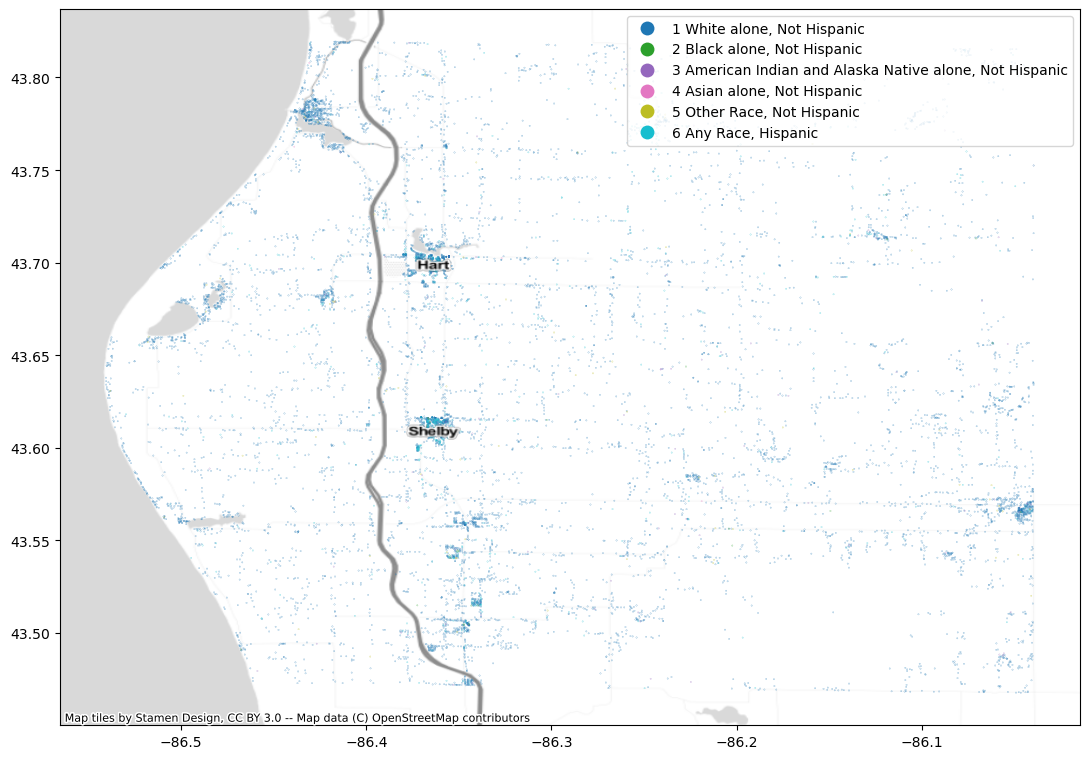

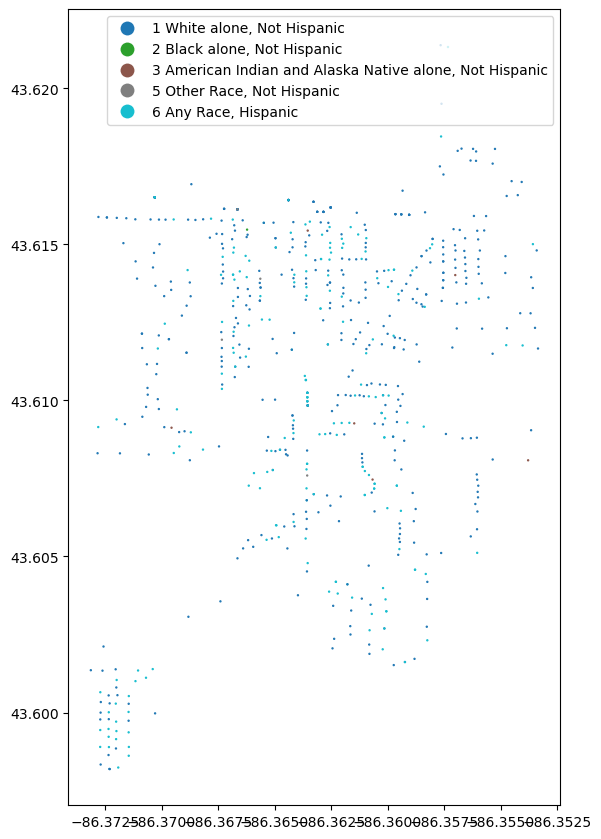

In [70]:
import contextily as cx # For adding basemap tiles to plot
import matplotlib.pyplot as plt # For plotting and making graphs

#mapname = 'hhincdotmap'
mapname = 'hhracedotmap'
# Map column
#map_var = 'Household Income Group'
map_var = 'Race Ethnicity'
condition1 = "(hua_hui_race_gdf.race >= 1)"
#condition3 = "(hua_hui_race_gdf['Building Data Availability_int'] == 1)"
place = focalplace
condition2 = f"(hua_hui_race_gdf.placeNAME10 == '{place}')"

condition_list = {1 : f"{condition1}",
                  2 : f"{condition1} & {condition2}"
                } 

for item in condition_list.keys():
    condition =  condition_list[item]
    # Obtain data
    popdata = hua_hui_race_gdf.loc[eval(condition)].copy(deep=True)
    hua_data = popdata.to_crs(epsg=4326)

    # Get min and max x and y values
    # Find the bounds of the gdf File
    minx = hua_data.bounds.minx.min()
    miny = hua_data.bounds.miny.min()
    maxx = hua_data.bounds.maxx.max()
    maxy = hua_data.bounds.maxy.max()
    x_range = maxx - minx
    #print(x_range)
    # make maker size inverse to the range of x values
    marker_size = .01/x_range
    #print(marker_size)

    # Set save file
    #  save hua_hui_gdf to csv
    check_folder = f"{outputfolder}/{community}/06_Explore"
    output_filename = f'{mapname}_{community}_{item}'
    filepath = check_folder+"/"+output_filename

    ''' Need to sort out figure and axes
    # Set figure size (width, height) in inches
    #plt.figure(figsize = ( 14 , 12 ))
    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    # Figure Title
    by_label = "Race Ethnicity"
    who = f"Housing Unit Locations"
    what = f"by {by_label}"
    where = "Lumberton, NC"
    when = "2010"
    table_title = who +" "+ what+", \n "+ where +", "+ when +"."


    # Set title for figure
    plt.title( table_title, size = 18)

    notes = "notes here"
    plt.gcf().text(0, 0, notes, 
                            va = 'bottom', ha='left',
                            fontstyle='italic', size=6)
    '''

    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    
    # Plot the data
    ax = hua_data.plot(column=map_var,
                        categorical=True, 
                        legend=True, 
                        markersize = marker_size)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLabels)

    ax.figure.savefig(filepath+'v2.svg', 
                bbox_inches="tight",format = 'svg', 
                dpi=600)

    ax.figure.savefig(filepath+'v2.png', 
                bbox_inches="tight",format = 'png', 
                dpi=600)


In [ ]:
communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'focalplace_name' : 'Lumberton',
                    'STATE' : 'NORTH_CAROLINA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}},
                    'building_inventory' : { 
                        'id' : '62ab7dcbf328861e25ffea9e',
                        'note' : 'Building inventory for Robeson County, NC',
                        'archetype_var' : 'archetype',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }
communities = {'Galveston_TX' : {
                    'community_name' : 'Galveston, TX',
                    'focalplace_name' : 'Galveston',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48167', 'Name' : 'Galveston County, TX'}},
                    'building_inventory' : { 
                        'id' : '63053ddaf5438e1f8c517fed',
                        'note' : 'Building inventory for Galveston County, TX',
                        'archetype_var' : 'arch_flood',
                        'residential_archetypes' : Nofal_residential_archetypesv2,
                        'building_area_var' : 'sq_foot'}
                                }
                }

communities = {'Mayfield_KY' : {
                    'community_name' : 'Mayfield, KY',
                    'focalplace_name' : 'Mayfield',
                    'STATE' : 'KENTUCKY',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '21083', 'Name' : 'Graves County, KY'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Graves County, KY',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }


communities = {'Beaumont_TX' : {
                    'community_name' : 'Beaumont, TX',
                    'focalplace_name' : 'Beaumont',
                    'STATE' : 'TEXAS',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '48245', 'Name' : 'Jefferson, TX'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Jefferson County, TX',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }

communities = {'Oceana_MI' : {
                    'community_name' : 'Pentwater, MI',
                    'focalplace_name' : 'Pentwater',
                    'STATE' : 'MICHIGAN',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '26127', 'Name' : 'Oceana County, MI'}},
                    'building_inventory' : { 
                        'id' : 'NSI',
                        'note' : 'NSI Building inventory for Oceana County, MI',
                        'archetype_var' : 'occtype',
                        'bldg_uniqueid' : 'fd_id_bid',
                        'residential_archetypes' : HAZUS_residential_archetypes,
                        'building_area_var' : 'sqft',
                        'building_area_cutoff' : 300}
                                }
                }